## EDA template

In [18]:
import numpy as np
import pandas as pd
import pandas_profiling as pp
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
raw_df = pd.read_csv('data/Train.zip')

/Users/franzmornau/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (13,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 1. Data Analysis
#### Meta data
* How many samples and features?
* What features are numeric vs. categorical

#### Data
* Inconsistent value types
* Missing values
* Zero values
* Incorrect values: sold before manufactured

In [10]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 53 columns):
SalesID                     401125 non-null int64
SalePrice                   401125 non-null int64
MachineID                   401125 non-null int64
ModelID                     401125 non-null int64
datasource                  401125 non-null int64
auctioneerID                380989 non-null float64
YearMade                    401125 non-null int64
MachineHoursCurrentMeter    142765 non-null float64
UsageBand                   69639 non-null object
saledate                    401125 non-null object
fiModelDesc                 401125 non-null object
fiBaseModel                 401125 non-null object
fiSecondaryDesc             263934 non-null object
fiModelSeries               56908 non-null object
fiModelDescriptor           71919 non-null object
ProductSize                 190350 non-null object
fiProductClassDesc          401125 non-null object
state                       4

In [15]:
pp.ProfileReport(raw_df)

Number of variables,53
Number of observations,401125
Total Missing (%),54.5%
Total size in memory,162.2 MiB
Average record size in memory,424.0 B
Numeric,8
Categorical,44
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [20]:
# pd.plotting.scatter_matrix(raw_df)
# better use seaborn pairplot, see next cell

/Users/franzmornau/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/franzmornau/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


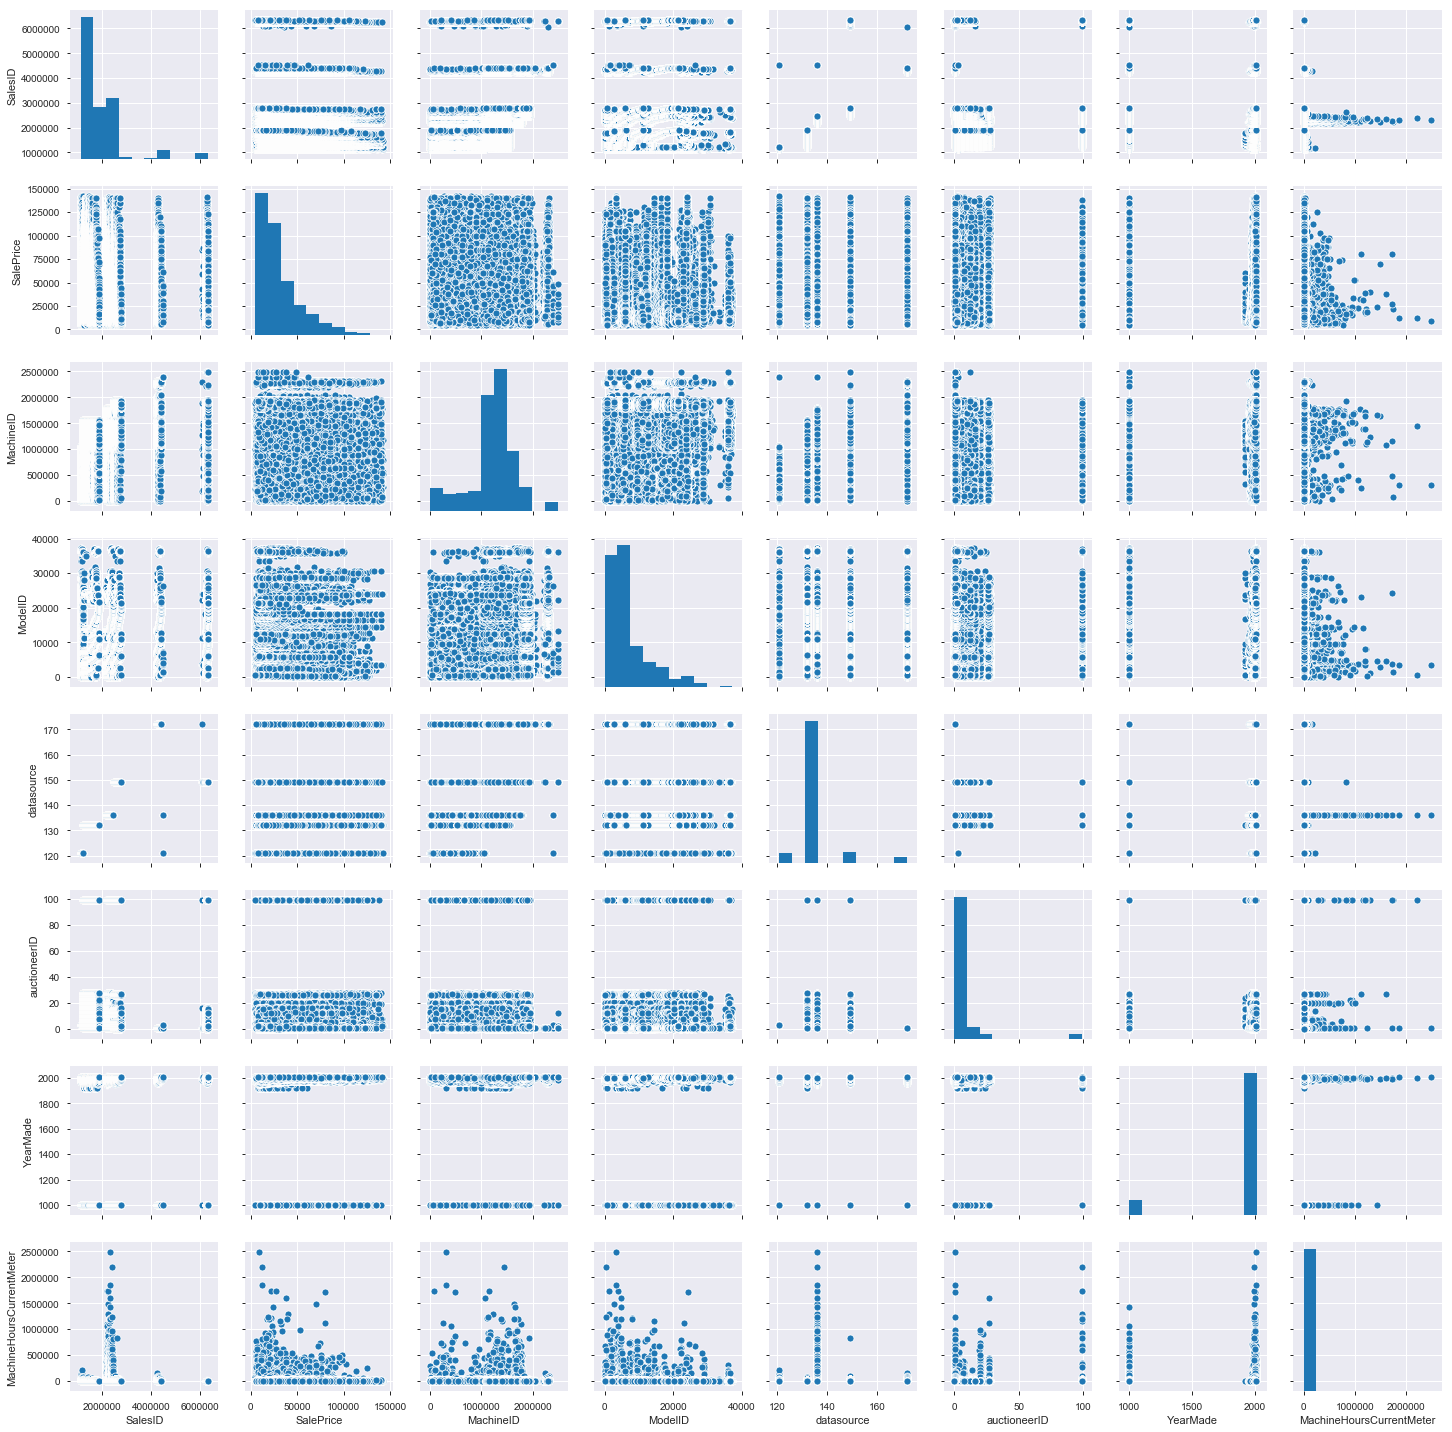

In [19]:
sns.pairplot(raw_df)

In [ ]:
# Useful to get actual correlation numbers
sns.heatmap(raw_df.corr(), annot=True)

# 2. Data Cleaning and Preparation
## 2.1 Dates to numerical

In [26]:
# getting correlations with dates by using date2num
import matplotlib.dates as dt
dt.num2date(300)

datetime.datetime(1, 10, 27, 0, 0, tzinfo=datetime.timezone.utc)

In [32]:
pd.to_datetime(raw_df['saledate'][3])

Timestamp('2011-05-19 00:00:00')

In [34]:
dt.date2num(pd.to_datetime(raw_df['saledate'][3]))
#type(raw_df['saledate'][3])

734276.0

## 2.2 Fill missing values